# P5: Vehicle Detection and Tracking

In [1]:
# Importing dependencies
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import time
import os
from sklearn.svm import LinearSVC, NuSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
%matplotlib inline

# 1. Data Exploration

8792 cars and 8968 non-cars
Size: (64, 64, 3) and data type: float32


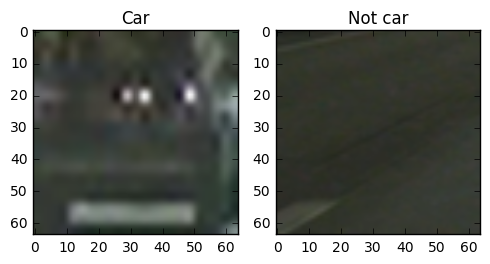

In [2]:
# Reading paths to vehicles and non-vehicles images
images = glob.glob('./vehicles/*/*.png')
cars = []
for image in images:
    cars.append(image)

images = glob.glob('./non-vehicles/*/*.png')
notcars = []
for image in images:
    notcars.append(image)

# Defining a function to return characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Defining a key in data_dict 'n_cars' and storing the number of car images
    data_dict['n_cars'] = len(car_list)
    # Defining a key 'n_notcars' and storing the number of notcar images
    data_dict['n_notcars'] = len(notcar_list)
    # Reading a test image
    example_img = mpimg.imread(car_list[0])
    # Defining a key 'image_shape' and storing the test image shape 3-tuple
    data_dict['image_shape'] = example_img.shape
    # Defining a key 'data_type' and storing the data type of the test image.
    data_dict['data_type'] = example_img.dtype
    # Returning data_dict
    return data_dict
    
# Displaying information about dataset
data_info = data_look(cars, notcars)
print(data_info['n_cars'], 'cars and', 
      data_info['n_notcars'], 'non-cars')
print('Size:',data_info['image_shape'], 'and data type:', 
      data_info['data_type'])
    
# Reading random a car and not car images
np.random.seed(np.random.randint(0, 100))
car_image = cv2.imread(cars[np.random.randint(0, len(cars))])
notcar_image = cv2.imread(notcars[np.random.randint(0, len(notcars))])

# Displaying example images
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(5,5))
ax[0].imshow(car_image)
ax[0].set_title('Car')
ax[1].imshow(notcar_image)
ax[1].set_title('Not car')
f.tight_layout()

# 2. Pipeline (single images)

## 2.1. Color Spaces Exploration
Color spaces exploration is a way to find what kind of feature (color channel) can be used to distinguish a target object (in our case - a car) from other objects and background.

In [6]:
# Defining function to convert color space
def conv_color_space(img, color_space='RGB'):
    if color_space == 'HSV':
        img_conv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        img_conv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
        img_conv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif color_space == 'YUV':
        img_conv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
        img_conv = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    elif color_space == 'LAB':
        img_conv = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    elif color_space == 'XYZ':
        img_conv = cv2.cvtColor(img, cv2.COLOR_RGB2XYZ)
    elif color_space == 'GRAY':
        img_conv = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else: img_conv = np.copy(img)
    
    return img_conv

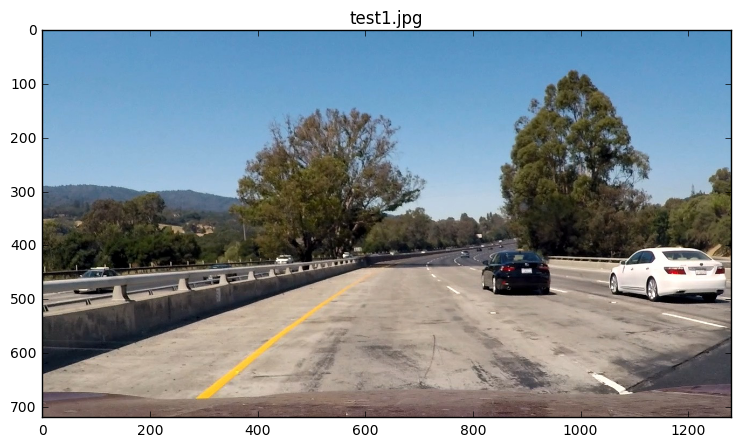

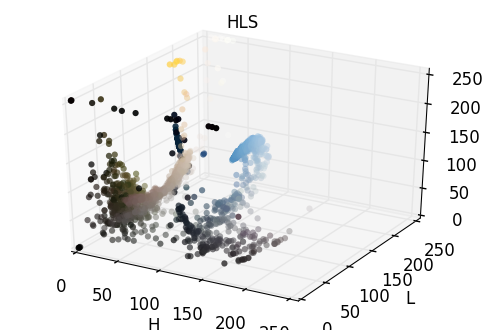

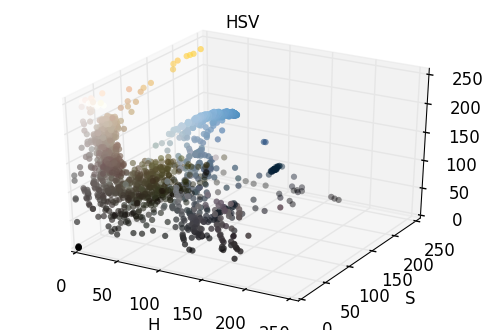

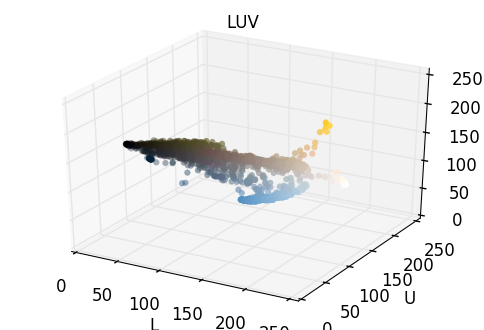

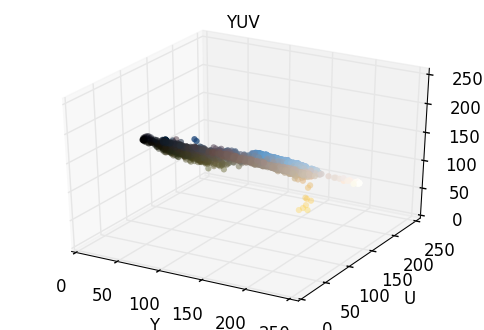

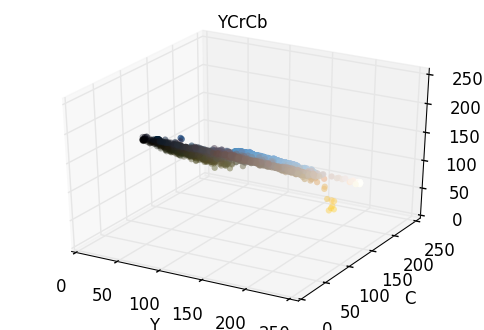

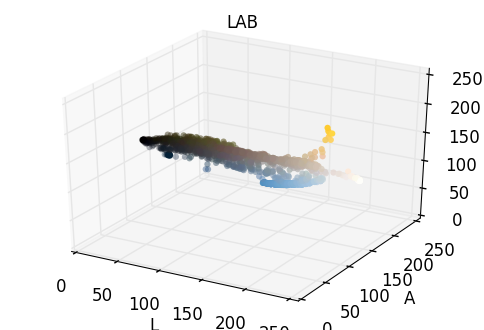

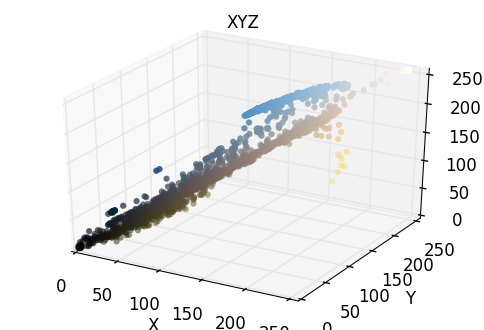

In [4]:
# Defining fucntion to draw 3D image representaions in different color spaces
def colorspace_repr(img, color_space='RGB'):
    # Selecting a small fraction of pixels to plot by subsampling it
    scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
    img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)
    img_small_rgb = img_small / 255.  # scaled to [0, 1], only for plotting
 
    # Converting subsampled image to different color spaces
    img_small_conv = conv_color_space(img_small, color_space=color_space)    

    # Drawing 3D scatter plot
    fig = plt.figure()
    ax3 = fig.add_subplot(111, projection='3d')
    # Setting axis limits
    ax3.set_xlim((0,255))
    ax3.set_ylim((0,255))
    ax3.set_zlim((0,255))
    ax3.set_title(color_space)
    # Setting axis labels and sizes
    ax3.tick_params(axis='both', which='major', labelsize=12, pad=8)
    axis_labels = list(color_space)
    ax3.set_xlabel(axis_labels[0], fontsize=12, labelpad=10)
    ax3.set_ylabel(axis_labels[1], fontsize=12, labelpad=10)
    ax3.set_zlabel(axis_labels[2], fontsize=12, labelpad=10)
    # Plotting pixel values with colors given in colors_rgb
    ax3.scatter(
        img_small_conv[:, :, 0].ravel(),
        img_small_conv[:, :, 1].ravel(),
        img_small_conv[:, :, 2].ravel(),
        c=img_small_rgb.reshape((-1, 3)), edgecolors='none')

# Displaying test image and its 3D representaions in different color spaces
files = [x for x in os.listdir('test_images/') if ('.db' not in x)]
f, ax = plt.subplots(figsize=(10,5))
# Reading image
image = mpimg.imread('test_images/' + files[0])        
# Drawing test image
ax.imshow(image)
ax.set_title(files[0])

# Drawing 3D image representaions in different color spaces
colorspace_repr(image, 'HLS')
colorspace_repr(image, 'HSV')
colorspace_repr(image, 'LUV')
colorspace_repr(image, 'YUV')
colorspace_repr(image, 'YCrCb')
colorspace_repr(image, 'LAB')
colorspace_repr(image, 'XYZ')

HLS and HSV 3D color space representations make car colors more distinguishable because of saturation. It may be used in features exctraction.

## 2.2. Spatial Binning of Color

In [4]:
# Defining function to compute spatially binned features
def bin_spatial(img, color_space='RGB', channel=[0,1,2], size=(16, 16)):
    # Converting into other color space
    img_conv = conv_color_space(img, color_space=color_space)
    # Creating the feature vector
    features = cv2.resize(img_conv, size, interpolation=cv2.INTER_LINEAR)#INTER_LANCZOS4 INTER_AREA INTER_LINEAR INTER_CUBIC
    result = []
    for i in channel:
        result.extend(features[:,:,i].ravel())
    return result

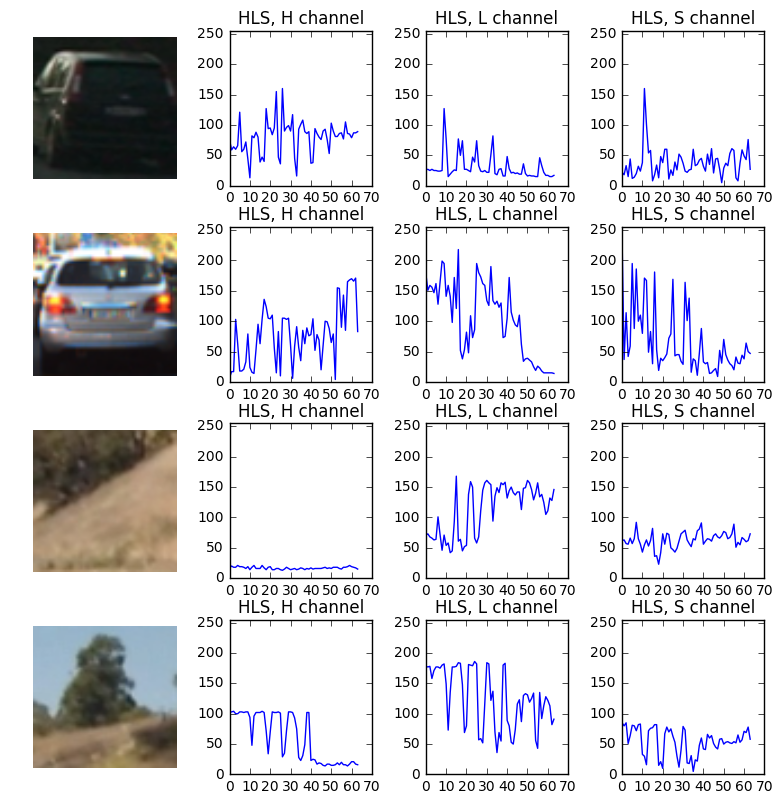

In [8]:
# Choosing image examples from dataset: 2 cars and 2 not cars
np.random.seed(np.random.randint(0, 100))
cars_id = np.random.randint(0, len(cars), size=2)
notcars_id = np.random.randint(0, len(notcars), size=2)

# Displaying images from dataset and hog images with different parameters
f, ax = plt.subplots(nrows=4, ncols=4, figsize=(8,8))
f.tight_layout() 

for i, ind in enumerate(np.concatenate((cars_id, notcars_id))):
    if i < len(cars_id):
        image = cv2.cvtColor(cv2.imread(cars[ind]), cv2.COLOR_BGR2RGB)
    else:
        image = cv2.cvtColor(cv2.imread(notcars[ind]), cv2.COLOR_BGR2RGB)
    ax[i,0].imshow(image)
    ax[i,0].axis('off')

    # Displaying spatial features
    spatial_color_space = 'HLS'
    spatial_channel = [0]
    spatial_size = (8,8)
    features = bin_spatial(image, color_space=spatial_color_space,
                           channel=spatial_channel, size=spatial_size)
    ax[i,1].plot(features)
    ax[i,1].set_ylim((0,255))
    ax[i,1].set_title(spatial_color_space+', '+list(spatial_color_space)[spatial_channel[0]]+' channel')
    
    spatial_color_space = 'HLS'
    spatial_channel = [1]
    spatial_size = (8,8)
    features = bin_spatial(image, color_space=spatial_color_space,
                           channel=spatial_channel, size=spatial_size)
    ax[i,2].plot(features)
    ax[i,2].set_ylim((0,255))
    ax[i,2].set_title(spatial_color_space+', '+list(spatial_color_space)[spatial_channel[0]]+' channel')

    spatial_color_space = 'HLS'
    spatial_channel = [2]
    spatial_size = (8,8)
    features = bin_spatial(image, color_space=spatial_color_space,
                           channel=spatial_channel, size=spatial_size)
    ax[i,3].plot(features)
    ax[i,3].set_ylim((0,255))
    ax[i,3].set_title(spatial_color_space+', '+list(spatial_color_space)[spatial_channel[0]]+' channel')

From pictures above, we can see that all three HLS channels can be used for creating feature vector.

## 2.3. Histograms of Color

In [9]:
# Defining function to compute color histogram features 
def color_hist(img, color_space='RGB', channel=[0,1,2], nbins=16, bins_range=(0, 256), vis=False):
    # Converting into other color space
    img_conv = conv_color_space(img, color_space=color_space)
    # Concatenating the histograms into a single feature vector
    channels = []
    for i in channel:
        hist = np.histogram(img_conv[:,:,i], bins=nbins, range=bins_range)
        channels.append(hist[0])
    if vis:
        bin_centers = (hist[1][1:] + hist[1][0:len(hist[1])-1])/2
        if len(channels)==1:
            return bin_centers, channels[0]
        elif len(channels)==2:
            return np.concatenate((channels[0], channels[1]))
        else:
            return np.concatenate((channels[0], channels[1], channels[2]))
    else:
        if len(channels)==1:
            return channels[0]
        elif len(channels)==2:
            return np.concatenate((channels[0], channels[1]))
        else:
            return np.concatenate((channels[0], channels[1], channels[2]))

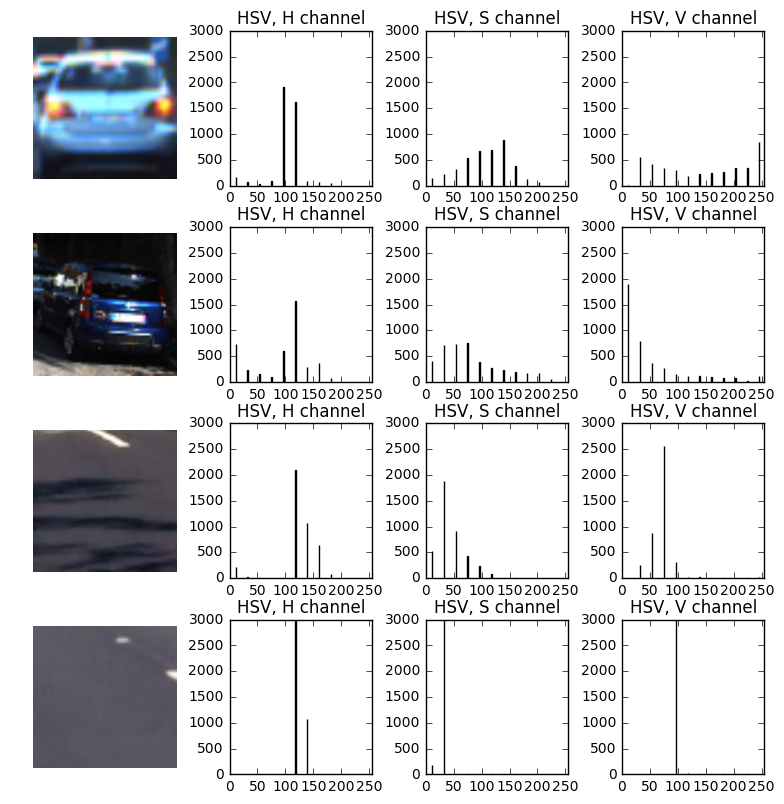

In [10]:
# Choosing image examples from dataset: 2 cars and 2 not cars
np.random.seed(np.random.randint(0, 100))
cars_id = np.random.randint(0, len(cars), size=2)
notcars_id = np.random.randint(0, len(notcars), size=2)

# Displaying images from dataset and hog images with different parameters
f, ax = plt.subplots(nrows=4, ncols=4, figsize=(8,8))
f.tight_layout() 

for i, ind in enumerate(np.concatenate((cars_id, notcars_id))):
    if i < len(cars_id):
        image = cv2.cvtColor(cv2.imread(cars[ind]), cv2.COLOR_BGR2RGB)
    else:
        image = cv2.cvtColor(cv2.imread(notcars[ind]), cv2.COLOR_BGR2RGB)
    ax[i,0].imshow(image)
    ax[i,0].axis('off')

    # Displaying spatial features
    hist_color_space = 'HSV'
    hist_channel = [0]
    hist_bins = 12
    bin_centers, features = color_hist(image, color_space=hist_color_space,
                                       channel=hist_channel, nbins=hist_bins, vis=True)
    ax[i,1].bar(bin_centers, features)
    ax[i,1].set_xlim((0,255))
    ax[i,1].set_ylim((0,3000))
    ax[i,1].set_title(hist_color_space+', '+list(hist_color_space)[hist_channel[0]]+' channel')

    hist_color_space = 'HSV'
    hist_channel = [1]
    hist_bins = 12
    bin_centers, features = color_hist(image, color_space=hist_color_space,
                                       channel=hist_channel, nbins=hist_bins, vis=True)
    ax[i,2].bar(bin_centers, features)
    ax[i,2].set_xlim((0,255))
    ax[i,2].set_ylim((0,3000))
    ax[i,2].set_title(hist_color_space+', '+list(hist_color_space)[hist_channel[0]]+' channel')
    
    hist_color_space = 'HSV'
    hist_channel = [2]
    hist_bins = 12
    bin_centers, features = color_hist(image, color_space=hist_color_space,
                                       channel=hist_channel, nbins=hist_bins, vis=True)
    ax[i,3].bar(bin_centers, features)
    ax[i,3].set_xlim((0,255))
    ax[i,3].set_ylim((0,3000))
    ax[i,3].set_title(hist_color_space+', '+list(hist_color_space)[hist_channel[0]]+' channel')

All HSV channels differentiate car and non-car images. From histograms we can see that an image with monotonous colors (2 pictures in the last two rows) gives bigger values for histograms than images which include different colors.

## 2.4. Histogram of Oriented Gradients (HOG)

In [12]:
# Defining a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     color_space='RGB', channel=[0,1,2],
                     vis=False, feature_vec=True):
    # Converting into other color space
    img_conv = conv_color_space(img, color_space=color_space) 

    # Calling with two outputs if vis==True 
    if vis == True:
        if color_space != 'GRAY':
            features, hog_image = hog(img_conv[:,:,channel[0]], orientations=orient,
                                      pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block),
                                      transform_sqrt=True, visualise=vis, feature_vector=feature_vec)
        else:
            features, hog_image = hog(img_conv, orientations=orient,
                                      pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block),
                                      transform_sqrt=True, visualise=vis, feature_vector=feature_vec)            
        return features, hog_image
    # Otherwise calling with one output
    else:      
        if color_space != 'GRAY':
            features = []
            for i in channel:
                features.extend(hog(img_conv[:,:,i], orientations=orient, 
                                    pixels_per_cell=(pix_per_cell, pix_per_cell),
                                    cells_per_block=(cell_per_block, cell_per_block),
                                    transform_sqrt=True, visualise=vis, feature_vector=feature_vec))
        else:
            features = hog(img_conv, orientations=orient,
                           pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block),
                           transform_sqrt=True, visualise=vis, feature_vector=feature_vec) 
        return features

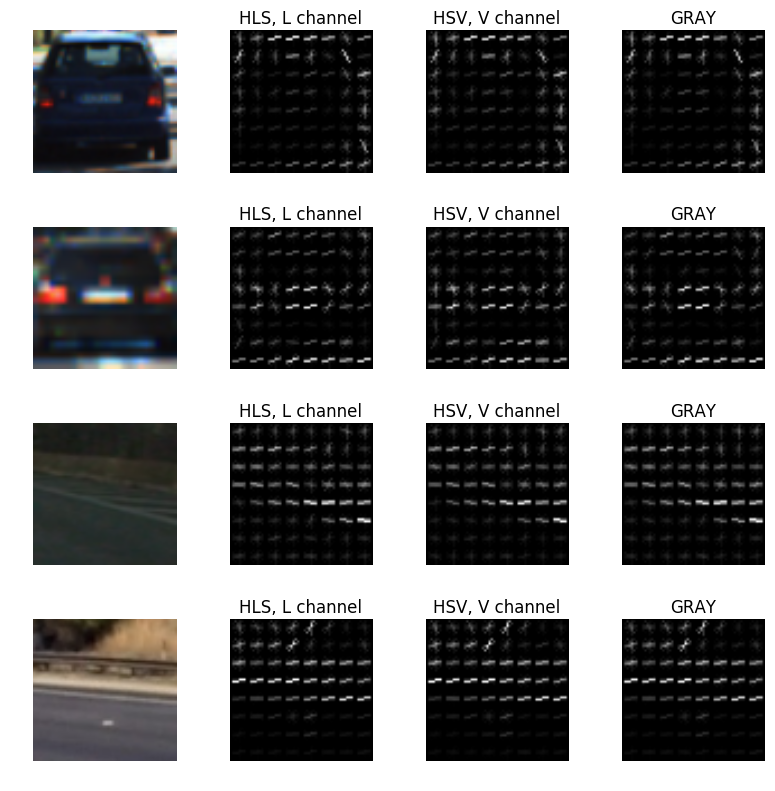

In [18]:
# Choosing image examples from dataset: 2 cars and 2 not cars
np.random.seed(np.random.randint(0, 100))
cars_id = np.random.randint(0, len(cars), size=2)
notcars_id = np.random.randint(0, len(notcars), size=2)

# Displaying images from dataset and hog images with different parameters
f, ax = plt.subplots(nrows=4, ncols=4, figsize=(8,8))
f.tight_layout() 

for i, ind in enumerate(np.concatenate((cars_id, notcars_id))):
    if i < len(cars_id):
        image = cv2.cvtColor(cv2.imread(cars[ind]), cv2.COLOR_BGR2RGB)
    else:
        image = cv2.cvtColor(cv2.imread(notcars[ind]), cv2.COLOR_BGR2RGB)
    ax[i,0].imshow(image)
    ax[i,0].axis('off')

    # Displaying hog images
    hog_color_space = 'HLS'
    hog_channel = [1]
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    features, hog_image = get_hog_features(image, orient, pix_per_cell, cell_per_block,
                                           color_space=hog_color_space, channel=hog_channel,
                                           vis=True, feature_vec=True)
    ax[i,1].imshow(hog_image, cmap='gray')
    ax[i,1].set_title(hog_color_space+', '+list(hog_color_space)[hog_channel[0]]+' channel')
    ax[i,1].axis('off')

    hog_color_space = 'HSV'
    hog_channel = [2]
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    features, hog_image = get_hog_features(image, orient, pix_per_cell, cell_per_block,
                                           color_space=hog_color_space, channel=hog_channel,
                                           vis=True, feature_vec=True)
    ax[i,2].imshow(hog_image, cmap='gray')
    ax[i,2].set_title(hog_color_space+', '+list(hog_color_space)[hog_channel[0]]+' channel')
    ax[i,2].axis('off')

    hog_color_space = 'GRAY'
    hog_channel = []
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    features, hog_image = get_hog_features(image, orient, pix_per_cell, cell_per_block,
                                           color_space=hog_color_space, channel=hog_channel,
                                           vis=True, feature_vec=True)
    ax[i,3].imshow(hog_image, cmap='gray')
    ax[i,3].set_title(hog_color_space)
    ax[i,3].axis('off')

In pictures above represented channels of color spaces give 'readable' information, but finally I used GRAY color space.

## 2.5. Training classifier

In [11]:
# Function for concatenating different feautures: spatial binning of color, histogram of color, hog
def single_img_features(img, 
                        spatial_color_space='RGB', spatial_channel=[0,1,2], spatial_size=(16, 16),
                        hist_color_space='RGB', hist_channel=[0,1,2], hist_bins=16,
                        hog_color_space='RGB', hog_channel=[0,1,2], orient=9, 
                        pix_per_cell=8, cell_per_block=2,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    # Defining an empty list to receive features
    img_features = []
    # Computing spatial features if flag 'spatial_feat' is set
    if spatial_feat == True:
        spatial_features = bin_spatial(img, color_space=spatial_color_space, channel=spatial_channel,
                                       size=spatial_size)
        # Appending features to list
        img_features.append(spatial_features)
    # Computing histogram features if flag 'hist_feat' is set
    if hist_feat == True:
        hist_features = color_hist(img, color_space=hist_color_space, channel=hist_channel,
                                   nbins=hist_bins)
        # Appending features to list
        img_features.append(hist_features)
    # Computing HOG features if flag 'hog_feat' is set
    if hog_feat == True:
        hog_features = get_hog_features(img, orient=orient, pix_per_cell=pix_per_cell,
                                        cell_per_block=cell_per_block,
                                        color_space=hog_color_space, channel=hog_channel)
        # Appending features to list
        img_features.append(hog_features)

    # Returning concatenated array of features
    return np.concatenate(img_features)

In [69]:
# Defining hyperparameters
spatial_color_space='HLS'
spatial_channel=[0,1,2]
spatial_size=(8,8)

hist_color_space='HSV'
hist_channel=[0,1,2]
hist_bins=12

hog_color_space='GRAY'
hog_channel=[]
orient=9
pix_per_cell=18
cell_per_block=2

spatial_feat=True
hist_feat=True
hog_feat=True

t=time.time()
# Extracting car features
car_features = []
for file in cars:
    image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    car_features.append(single_img_features(image,
                                            spatial_color_space=spatial_color_space, spatial_channel=spatial_channel,
                                            spatial_size=spatial_size, hist_channel=hist_channel, hist_bins=hist_bins,
                                            hog_color_space=hog_color_space, hog_channel=hog_channel, orient=orient,
                                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat))

# Extracting non car features
notcar_features = []
for file in notcars:
    image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    notcar_features.append(single_img_features(image,
                                               spatial_color_space=spatial_color_space, spatial_channel=spatial_channel,
                                               spatial_size=spatial_size, hist_channel=hist_channel, hist_bins=hist_bins,
                                               hog_color_space=hog_color_space, hog_channel=hog_channel, orient=orient,
                                               pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                               spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat))


t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')
# Creating an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fitting a per-column scaler
X_scaler = StandardScaler().fit(X)
# Applying the scaler to X
scaled_X = X_scaler.transform(X)

# Defining the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Splitting up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))
# Using a linear SVC 
svc = LinearSVC()
#svc = NuSVC()
# Checking the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Checking the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Checking the prediction time for a single sample
t=time.time()
n_predict = 10
print('SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

51.73 Seconds to extract features...
Feature vector length: 372
6.31 Seconds to train SVC...
Test Accuracy of SVC =  0.9713
SVC predicts:  [ 1.  1.  1.  0.  0.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 1.  1.  1.  0.  0.  0.  0.  0.  1.  0.]
0.01563 Seconds to predict 10 labels with SVC


## 2.6. Sliding Windows Search

In [70]:
# Defining function for sliding windows
def slide_window(img, x_start_stop=[None, None],
                 y_start_stop={'min':[390, 500], 'mid1':[390, 590], 'max':[390, 670]}, 
                 xy_window={'min':[64, 64], 'mid1':[128, 128], 'max':[192, 192]},
                 xy_overlap={'min':[.5,.5], 'mid1':[.6,.5], 'max':[.5,.5]}):
    # If x start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]

    window_list = []

    for elem in y_start_stop:
        # Computing the span of the region to be searched    
        xspan = x_start_stop[1] - x_start_stop[0]
        yspan = y_start_stop[elem][1] - y_start_stop[elem][0]
        # Computing the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[elem][0]*(1 - xy_overlap[elem][0]))
        ny_pix_per_step = np.int(xy_window[elem][1]*(1 - xy_overlap[elem][1]))
        # Computing the number of windows in x/y
        nx_buffer = np.int(xy_window[elem][0]*(xy_overlap[elem][0]))
        ny_buffer = np.int(xy_window[elem][1]*(xy_overlap[elem][1]))
        nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
        ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
        # Looping through finding x and y window positions
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculating window position
                startx = xs*nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[elem][0]
                starty = ys*ny_pix_per_step + y_start_stop[elem][0]
                endy = starty + xy_window[elem][1]
                # Appending window position to list
                window_list.append(((startx, starty), (endx, endy)))
    # Returning the list of windows
    return window_list

# Defining a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Making a copy of the image
    imcopy = np.copy(img)
    # Iterating through the bounding boxes
    for bbox in bboxes:
        # Drawing a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Returning the image copy with boxes drawn
    return imcopy

# Defining a function to search a car in sliding windows 
def search_windows(img, windows, clf, scaler,
                   spatial_color_space='RGB', spatial_channel=[0,1,2], spatial_size=(16, 16),
                   hist_color_space='RGB', hist_channel=[0,1,2], hist_bins=16,
                   hog_color_space='RGB', hog_channel=[0,1,2], orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   spatial_feat=True, hist_feat=True, hog_feat=True):
    # Creating an empty list to receive positive detection windows
    on_windows = []
    # Iterating over all windows in the list
    for window in windows:
        # Extracting the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        # Extracting features for that window using single_img_features()
        features = single_img_features(test_img, 
                                       spatial_color_space=spatial_color_space, spatial_channel=spatial_channel,
                                       spatial_size=spatial_size, hist_channel=hist_channel, hist_bins=hist_bins,
                                       hog_color_space=hog_color_space, hog_channel=hog_channel, orient=orient,
                                       pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                       spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        # Scaling extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # Predicting using classifier
        prediction = clf.predict(test_features)
        # If positive (prediction == 1) then saving the window
        if prediction == 1:
            on_windows.append(window)
    # Returning windows for positive detections
    return on_windows

def add_heat(heatmap, bbox_list, threshold=3):
    # Iterating through list of bboxes
    for box in bbox_list:
        # Adding 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Applying threshold to reject areas affected by false positive
    heatmap[heatmap <= threshold] = 0
    # Returning updated heatmap
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterating through all detected cars
    for car_number in range(1, labels[1]+1):
        # Finding pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identifying x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Defining a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Drawing the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Returning the image
    return img

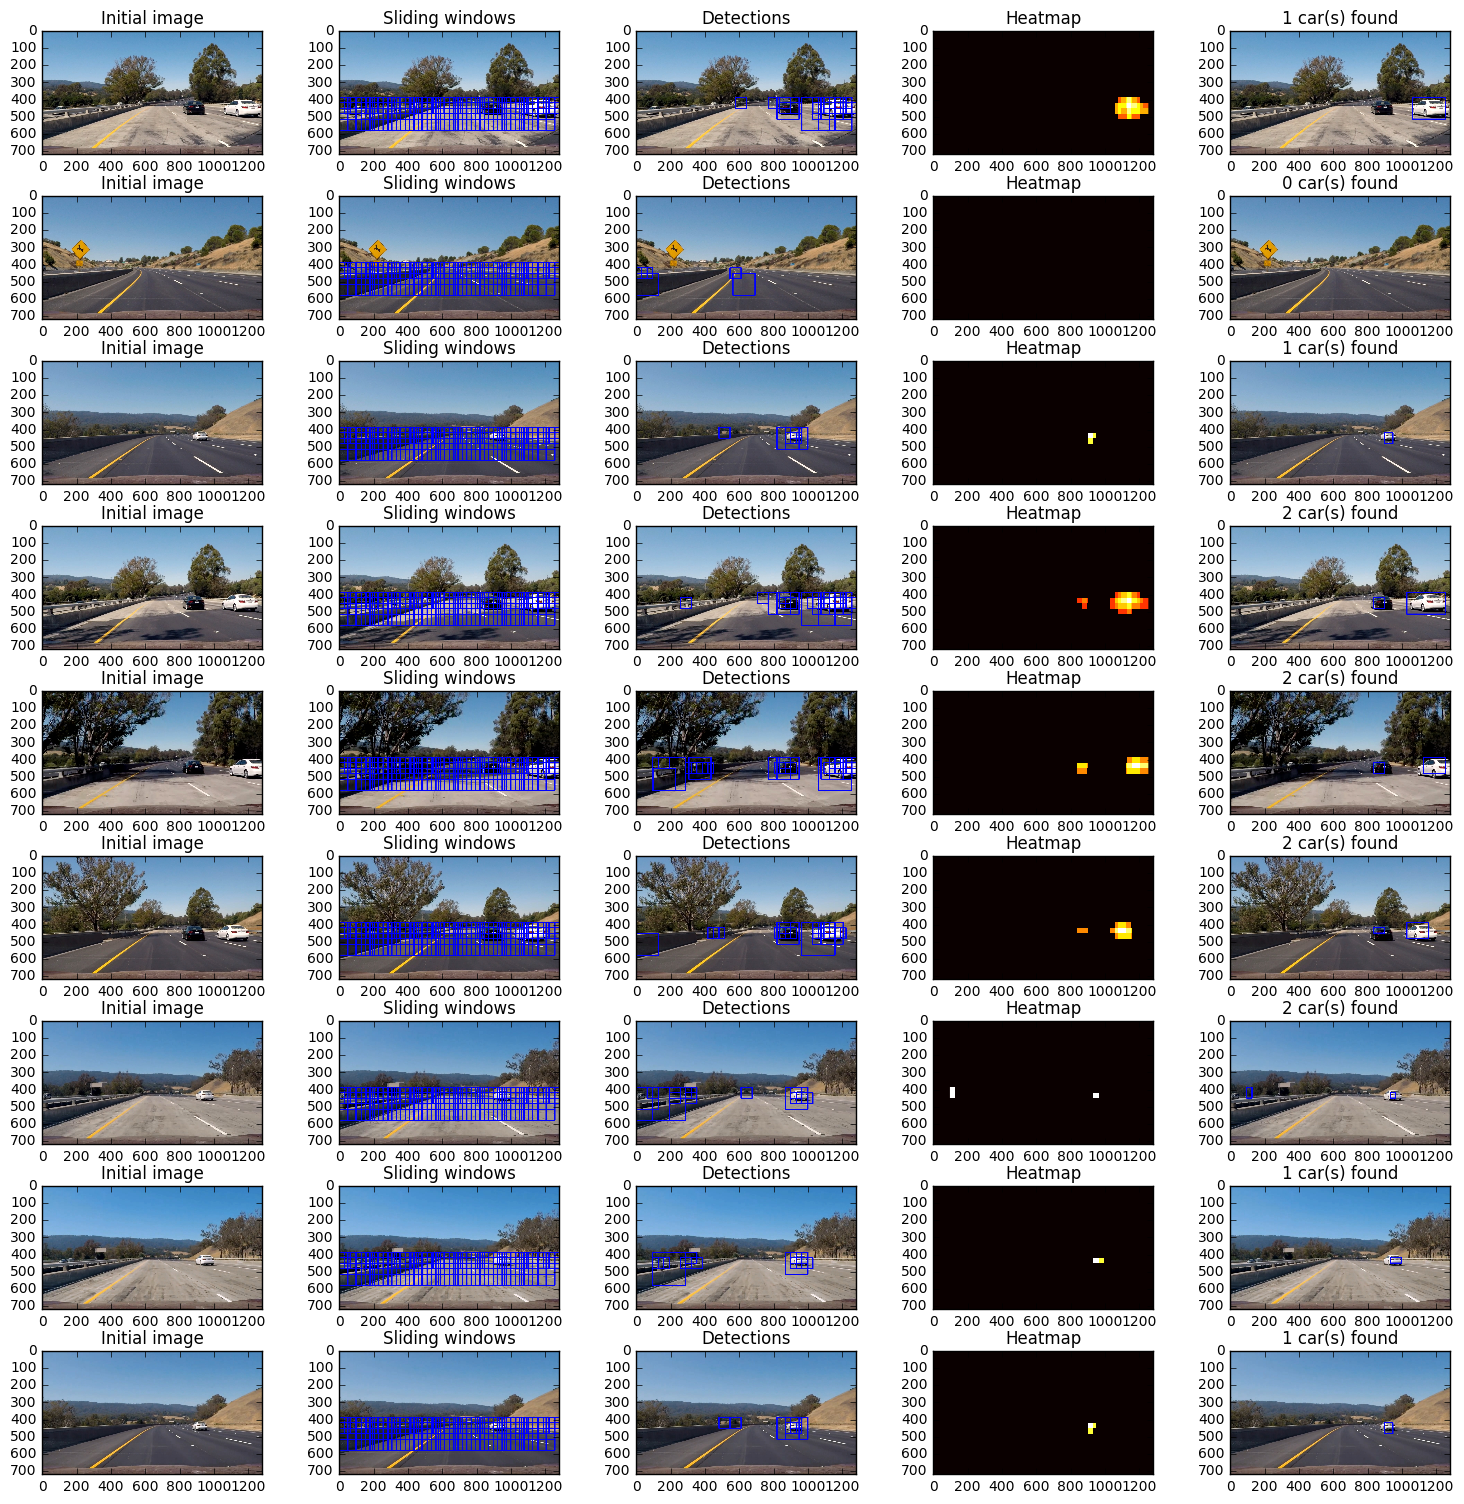

In [71]:
# Drawing test images with results
files = [x for x in os.listdir('test_images/') if ('.db' not in x)]
f, ax = plt.subplots(nrows=9, ncols=5, figsize=(15,15))
f.tight_layout()
# Iterating through all test images
for i, file in enumerate(files):
    image = cv2.cvtColor(cv2.imread('test_images/' + file), cv2.COLOR_BGR2RGB)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Finding sliding windows 
    boxes = slide_window(image)
    # Finding a car in sliding windows
    hot_boxes = search_windows(image, boxes, svc, X_scaler, 
                               spatial_color_space=spatial_color_space, spatial_channel=spatial_channel,
                               spatial_size=spatial_size, hist_channel=hist_channel, hist_bins=hist_bins,
                               hog_color_space=hog_color_space, hog_channel=hog_channel, orient=orient,
                               pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                               spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    # Drawing test images with sliding windows and windows where cars were detected
    draw_img = np.copy(image)
    ax[i,0].imshow(image)
    ax[i,0].set_title('Initial image')
    ax[i,1].imshow(draw_boxes(draw_img, boxes))
    ax[i,1].set_title('Sliding windows')
    ax[i,2].imshow(draw_boxes(draw_img, hot_boxes))
    ax[i,2].set_title('Detections')
    # Building a heatmap to exclude false positives
    heatmap = np.clip(add_heat(heat, hot_boxes), 0, 255)
    ax[i,3].imshow(heatmap, cmap='hot')
    ax[i,3].set_title('Heatmap')
    # Drawing regions of found cars
    labels = label(heatmap)
    ax[i,4].imshow(draw_labeled_bboxes(draw_img, labels))
    ax[i,4].set_title(str(labels[1])+' car(s) found')

The results, in most cases, coincide with number of cars.

# 3. Pipeline (video)

Below I combined functions for lane lines and vehicle detections.

In [73]:
# Function for building a binary image
def binary_image(img, yuv_thresh=(0,110), hsv_thresh=(240,255), sobel_thresh=(40,100), sobel_kernel=3):   
    # Converting an image to YUV color space
    yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)    
    # Applying a threshold to the V channel
    yuv_channel = yuv[:,:,2]
    yuv_binary = np.zeros_like(yuv_channel)
    yuv_binary[(yuv_channel >= yuv_thresh[0]) & (yuv_channel <= yuv_thresh[1])] = 1
    
    # Converting an image to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # Applying a threshold to the V channel
    hsv_channel = hsv[:,:,2]
    hsv_binary = np.zeros_like(hsv_channel)
    hsv_binary[(hsv_channel >= hsv_thresh[0]) & (hsv_channel <= hsv_thresh[1])] = 1
    
    # Converting an image to gray
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculating Sobel operator
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculating the gradient magnitude
    magnitude = np.sqrt(sobelx**2+0.01*sobely**2)
    # Rescaling to 8 bit
    scaled_sobel = np.uint8(255*magnitude/np.max(magnitude))
    # Applying a threshold
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1
    
    # Combining thresholds
    combined_binary = np.zeros_like(sobel_binary)
    combined_binary[(yuv_binary == 1) | (hsv_binary == 1) | (sobel_binary == 1)] = 1
    
    return combined_binary

# Defining Lane Lines and Car Detection function
def process_image1(img):
    global first_image, left_fit, right_fit
    # Undistorting image
    undist_img = cv2.undistort(img, dist_coeff['mtx'], dist_coeff['dist'], None, dist_coeff['mtx'])
    # Getting binary image
    binary = binary_image(undist_img)
    binary_3ch = np.dstack((binary, binary, binary))*255
    # Applying perspective transform
    binary_warped = cv2.warpPerspective(binary, persp_coeff['M'], (img.shape[1], img.shape[0]))
    # Identifying the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Setting the width of the windows
    margin = 90    
    # Set minimum number of pixels found to recenter window
    minpix = 30

    if first_image:
        # Taking a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
        # Finding the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choosing the number of sliding windows
        nwindows = 9    
        # Setting height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Creating empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Identifying the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Appending these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenating the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extracting left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fitting a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    else:
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Extracting left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fitting a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generating x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recasting the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    road = np.zeros_like(img)
    cv2.fillPoly(road, np.int_([pts]), color=[0,255,0])
    
    # Drawing car detections on initial image
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Finding sliding windows 
    boxes = slide_window(img)
    # Finding a car in sliding windows
    hot_boxes = search_windows(img, boxes, svc, X_scaler,
                               spatial_color_space=spatial_color_space, spatial_channel=spatial_channel,
                               spatial_size=spatial_size, hist_channel=hist_channel, hist_bins=hist_bins,
                               hog_color_space=hog_color_space, hog_channel=hog_channel, orient=orient,
                               pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                               spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)                             
    # Building a heatmap to exclude false positives
    heatmap = add_heat(heat, hot_boxes)
    # Finding how many cars in an image
    labels = label(heatmap)
    for car_number in range(1, labels[1]+1):
            # Finding pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identifying x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Defining a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Drawing the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    
    # Drawing lane lines on initial image
    road_warped = cv2.warpPerspective(road, persp_coeff['M_inv'], (img.shape[1], img.shape[0]))
    result = cv2.addWeighted(img, 1, road_warped, 0.7, 0)
    
    # Defining conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    # Fitting new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculating the new radius of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, 'Radius of Curvature = ' +str(round((left_curverad+right_curverad)/2,3))+'m', (50,50), font, 1, (255, 255, 255), 2)
    
    # Calculating the offset of the car on the road
    camera_center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center-binary_warped.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff <=0:
        side_pos = 'right'

    cv2.putText(result, 'Vehicle is ' +str(abs(round(center_diff,3)))+'m '+side_pos+' of center', (50,100), font, 1, (255, 255, 255), 2)
    first_image = False
    
    return result

In [74]:
# Loading distortion coefficients from pickle file
f = open('dist_coeff.p', 'rb')
dist_coeff = pickle.load(f)
f.close()

# Loading perspective coefficients from pickle file
f = open('persp_coeff.p', 'rb')
persp_coeff = pickle.load(f)
f.close()

first_image = True

input_clip = VideoFileClip('project_video.mp4')
output_clip = input_clip.fl_image(process_image1)
%time output_clip.write_videofile('output_project_video.mp4', audio=False)

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [13:39<00:00,  1.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

Wall time: 13min 41s


In [75]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output_project_video.mp4'))